In [1]:
import ruptures as rpt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az

/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# def bayesian_three_cp_forecast(df, feature_cols):
#     X = df[feature_cols].values
#     y = df['y'].values
#     n_obs, n_features = X.shape
#     idx = np.arange(n_obs)

#     with pm.Model() as model:
#         # Regime-specific parameters: Four regimes (0 to 3)
#         alphas = [pm.Normal(f'alpha_{i}', mu=0, sigma=1) for i in range(4)]
#         betas_raw = [pm.Normal(f'betas_{i}_raw', mu=0, sigma=1, shape=n_features) for i in range(4)]
#         beta_scale = pm.HalfNormal('beta_scale', sigma=1)
#         betas = [pm.Deterministic(f'betas_{i}', betas_raw[i] * beta_scale) for i in range(4)]
#         sigmas = [pm.Exponential(f'sigma_{i}', lam=50) for i in range(4)]

#         # Change points and their smoothness
#         tau1 = pm.Normal('tau1', mu=n_obs / 4, sigma=n_obs / 6)
#         tau2 = pm.Normal('tau2', mu=n_obs / 2, sigma=n_obs / 6)
#         tau3 = pm.Normal('tau3', mu=3 * n_obs / 4, sigma=n_obs / 6)

#         # tau1 = pm.Normal('tau1', mu=n_obs / 4, sigma=n_obs / 10)
#         # tau2 = pm.Normal('tau2', mu=n_obs / 2, sigma=n_obs / 10)
#         # tau3 = pm.Normal('tau3', mu=3 * n_obs / 4, sigma=n_obs / 10)

#         # from pymc.distributions.transforms import ordered

#         # taus = pm.Normal(
#         #     "taus", mu=[n_obs / 4, n_obs / 2, 3 * n_obs / 4], sigma=n_obs / 10, shape=3, transform=ordered
#         # )
#         # tau1, tau2, tau3 = taus[0], taus[1], taus[2]

#         #  # Diagnostics
#         # tau1 = pm.Deterministic('tau1', taus[0])
#         # tau2 = pm.Deterministic('tau2', taus[1])
#         # tau3 = pm.Deterministic('tau3', taus[2])

  

# #         taus = pm.Ordered('taus', pm.Normal.dist(mu=[n_obs/4, n_obs/2, 3*n_obs/4], sigma=n_obs/10), shape=3)
# # tau1, tau2, tau3 = taus[0], taus[1], taus[2]



#         # Smoothness (non-centered)
#         k1_raw = pm.Normal('kappa1_raw', 0, 1)
#         kappa1 = pm.Deterministic('kappa1', pm.math.clip(pm.math.abs(k1_raw) * 10, 1, 20))

#         k2_raw = pm.Normal('kappa2_raw', 0, 1)
#         kappa2 = pm.Deterministic('kappa2', pm.math.clip(pm.math.abs(k2_raw) * 10, 1, 20))

#         k3_raw = pm.Normal('kappa3_raw', 0, 1)
#         kappa3 = pm.Deterministic('kappa3', pm.math.clip(pm.math.abs(k3_raw) * 10, 1, 20))

#         # k1 = pm.Deterministic('kappa1', pm.math.abs(pm.Normal('kappa1_raw', 0, 1)) * 10)

#         # k2 = pm.Deterministic('kappa2', pm.math.abs(pm.Normal('kappa2_raw', 0, 1)) * 10)
#         # k3 = pm.Deterministic('kappa3', pm.math.abs(pm.Normal('kappa3_raw', 0, 1)) * 10)




#         # Smooth transitions
#         s1 = pm.math.invlogit((idx - tau1) / kappa1)
#         s2 = pm.math.invlogit((idx - tau2) / kappa2)
#         s3 = pm.math.invlogit((idx - tau3) / kappa3)

#         # Mixing weights for four regimes: ensure they sum to 1
#         w0 = (1 - s1)
#         w1 = s1 * (1 - s2)
#         w2 = s2 * (1 - s3)
#         w3 = s3

#         # w0 = (1 - s1)
#         # w1 =  s1 * (1 - s2)
#         # w2 =  s1 * s2 * (1 - s3)
#         # w3 =  s1 * s2 * s3


#         # Compute means for each regime
#         mus = [alphas[i] + pm.math.dot(X, betas[i]) for i in range(4)]
#         mu = w0 * mus[0] + w1 * mus[1] + w2 * mus[2] + w3 * mus[3]

#         # Combine sigmas
#         sigma_t = w0 * sigmas[0] + w1 * sigmas[1] + w2 * sigmas[2] + w3 * sigmas[3]

#         # Likelihood
#         y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_t, observed=y)

#         # record log‑likelihood for WAIC/LOO
#         logp = pm.logp(y_obs, y)
#         pm.Deterministic('log_likelihood', logp)


#         # Sampling
#         trace = pm.sample(
#             draws=3000,
#             tune=4000,
#             chains=4,
#             cores=4,
#             target_accept=0.99,
#             init="jitter+adapt_diag",
#             return_inferencedata=True,
#             idata_kwargs={"log_likelihood": True},
#         )


   

#     summary = az.summary(trace, var_names=['tau1', 'tau2', 'tau3', 'kappa1', 'kappa2', 'kappa3'], hdi_prob=0.95)
#     print(summary)

#     return model, trace


In [71]:
def bayesian_three_cp_forecast(df, feature_cols):
    X = df[feature_cols].values
    y = df['y'].values
    n_obs, n_features = X.shape
    idx = np.arange(n_obs)

    with pm.Model() as model:
        # Regime-specific parameters: Four regimes (0 to 3)
        alphas = [pm.Normal(f'alpha_{i}', mu=0, sigma=1) for i in range(4)]
        betas_raw = [pm.Normal(f'betas_{i}_raw', mu=0, sigma=1, shape=n_features) for i in range(4)]
        beta_scale = pm.HalfNormal('beta_scale', sigma=1)
        betas = [pm.Deterministic(f'betas_{i}', betas_raw[i] * beta_scale) for i in range(4)]
        sigmas = [pm.Exponential(f'sigma_{i}', lam=50) for i in range(4)]

        # # Change points and their smoothness
        # tau1 = pm.Normal('tau1', mu=n_obs / 4, sigma=n_obs / 6)
        # tau2 = pm.Normal('tau2', mu=n_obs / 2, sigma=n_obs / 6)
        # tau3 = pm.Normal('tau3', mu=3 * n_obs / 4, sigma=n_obs / 6)
        # Ensure change points are ordered
        tau1 = pm.Normal('tau1', mu=n_obs / 4, sigma=n_obs / 10)
        tau2 = pm.Normal('tau2', mu=tau1 + n_obs / 4, sigma=n_obs / 10)
        tau3 = pm.Normal('tau3', mu=tau2 + n_obs / 4, sigma=n_obs / 10)



        # Smoothness (non-centered)
        k1_raw = pm.Normal('kappa1_raw', 0, 1)
        kappa1 = pm.Deterministic('kappa1', pm.math.clip(pm.math.abs(k1_raw) * 10, 1, 20))

        k2_raw = pm.Normal('kappa2_raw', 0, 1)
        kappa2 = pm.Deterministic('kappa2', pm.math.clip(pm.math.abs(k2_raw) * 10, 1, 20))

        k3_raw = pm.Normal('kappa3_raw', 0, 1)
        kappa3 = pm.Deterministic('kappa3', pm.math.clip(pm.math.abs(k3_raw) * 10, 1, 20))



        # # Smooth transitions
        # s1 = pm.math.invlogit((idx - tau1) / kappa1)
        # s2 = pm.math.invlogit((idx - tau2) / kappa2)
        # s3 = pm.math.invlogit((idx - tau3) / kappa3)

        # # Mixing weights for four regimes: ensure they sum to 1
        # w0 = (1 - s1)
        # w1 = s1 * (1 - s2)
        # w2 = s2 * (1 - s3)
        # w3 = s3
                # Smoother transitions with regularization
        s1 = pm.math.invlogit((idx - tau1) / kappa1)
        s2 = pm.math.invlogit((idx - tau2) / kappa2)
        s3 = pm.math.invlogit((idx - tau3) / kappa3)

        # Small epsilon to prevent numerical issues
        epsilon = 1e-6

        # Mixing weights with regularization
        w0 = (1 - s1) + epsilon
        w1 = s1 * (1 - s2) + epsilon
        w2 = s1 * s2 * (1 - s3) + epsilon
        w3 = s1 * s2 * s3 + epsilon

        # Normalize weights to sum to 1
        total = w0 + w1 + w2 + w3
        w0 = w0 / total
        w1 = w1 / total
        w2 = w2 / total
        w3 = w3 / total

        

        # Compute means for each regime
        mus = [alphas[i] + pm.math.dot(X, betas[i]) for i in range(4)]
        mu = w0 * mus[0] + w1 * mus[1] + w2 * mus[2] + w3 * mus[3]

        # Combine sigmas
        sigma_t = w0 * sigmas[0] + w1 * sigmas[1] + w2 * sigmas[2] + w3 * sigmas[3]

        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_t, observed=y)

        # Sampling
        trace = pm.sample(
            draws=3000,
            tune=6000,
            chains=4,
            cores=4,
            target_accept=0.99,
            init="jitter+adapt_diag",
            return_inferencedata=True,
            idata_kwargs={"log_likelihood": True},
        )


   

    summary = az.summary(trace, var_names=['tau1', 'tau2', 'tau3', 'kappa1', 'kappa2', 'kappa3'], hdi_prob=0.95)
    print(summary)

    return model, trace


Function signature & docstring

Declares that we’ll infer one change-point (τ) and two sets of regression parameters.

X = df[feature_cols].values

Grabs your standardized predictors (lagged returns, VIX, sentiment features) as a NumPy array of shape (n_obs × n_features).

y = df['y'].values

Your target series: the next-day return at each time t.

n_obs, n_features = X.shape

Number of days (observations) and number of predictors.

idx = np.arange(n_obs)

Integer index array [0,1,2,…,n_obs−1] used to decide “which regime” each day belongs to relative to τ

In [ ]:
# MCMC ✔️
# We’re using PyMC3’s pm.sample() (which under the hood runs the No-U-Turn Sampler, a form of Hamiltonian Monte Carlo) to jointly draw from the posterior over

# the change-point index τ

# both sets of regression parameters (α₀/β₀/σ₀ and α₁/β₁/σ₁)
# This is your “MCMC” step, fully implemented.



# Your Current Implementation (Bayesian Change-Point Regression)
# Your current approach:

# Is retrospective - analyzes the entire historical dataset at once
# Identifies a single change-point in the historical data
# Estimates two separate regimes with different parameter sets
# Requires retraining from scratch when new data arrives
# Works well for understanding historical structural breaks

In [6]:
import ruptures as rpt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az
df = pd.read_csv('../ready_Data/df_daily_last.csv')  # Has: date, title, descriptio



In [7]:
# 1. Standardize (zero‐mean, unit‐std) each series so neither dominates
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['sent_roll3_std', 'vix_chg1_std']] = scaler.fit_transform(
    df[['polarity_x_strong_roll3', 'vix_chg1']]
)

# 2. Create the interaction (volatility‐weighted sentiment)
df['sent_vix'] = df['sent_roll3_std'] * df['vix_chg1_std']

# feature_cols =[
#     'ret_lag1','ret_roll5','vix_lag1','vix_chg1','sent_vix']

feature_cols =[
    'ret_lag1','ret_roll5','vix_lag1','vix_chg1']


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1908 non-null   object 
 1   date.1                   1908 non-null   object 
 2   close_sp500              1908 non-null   float64
 3   close_vix                1908 non-null   float64
 4   polarity_x_strong        1908 non-null   float64
 5   y                        1908 non-null   float64
 6   ret_lag1                 1908 non-null   float64
 7   ret_roll5                1908 non-null   float64
 8   vix_lag1                 1908 non-null   float64
 9   vix_chg1                 1908 non-null   float64
 10  polarity_x_strong_lag1   1908 non-null   float64
 11  polarity_x_strong_roll3  1908 non-null   float64
 12  sent_roll3_std           1908 non-null   float64
 13  vix_chg1_std             1908 non-null   float64
 14  sent_vix                

In [72]:

# =====================================================================
# SECTION 5: Evaluation & Baseline Comparison
# Compare against ARIMA/LSTM as described in proposal
# =====================================================================

# (Implement ARIMA, LSTM training and then compute MAE, RMSE, log-likelihood)

if __name__ == '__main__':


    # 1) Chronological train/test split (80 % train, 20 % test)
    n = len(df)
    split_idx = int(0.8 * n)

    df_train = df.iloc[:split_idx].copy()
    df_test  = df.iloc[split_idx:].copy()

    print(f"Training on {len(df_train)} rows, testing on {len(df_test)} rows")

    # 2) Fit your Bayesian change‐point model on df_train only
    model, trace = bayesian_three_cp_forecast(df_train, feature_cols)

 


Training on 1526 rows, testing on 382 rows


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_0, alpha_1, alpha_2, alpha_3, betas_0_raw, betas_1_raw, betas_2_raw, betas_3_raw, beta_scale, sigma_0, sigma_1, sigma_2, sigma_3, tau1, tau2, tau3, kappa1_raw, kappa2_raw, kappa3_raw]


Sampling 4 chains for 6_000 tune and 3_000 draw iterations (24_000 + 12_000 draws total) took 4007 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


            mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
tau1     299.758   11.408   275.790    320.275      3.657    2.668      10.0   
tau2    1000.975  227.615   596.455   1139.631    113.595   87.034       7.0   
tau3    1147.076   12.796  1121.652   1159.923      6.255    4.774       7.0   
kappa1    19.542    1.100    17.061     20.000      0.013    0.009   11461.0   
kappa2     3.227    2.487     1.000      8.178      0.485    0.347      94.0   
kappa3     2.345    2.206     1.000      7.509      0.191    0.136     181.0   

        ess_tail  r_hat  
tau1        28.0   1.29  
tau2        29.0   1.53  
tau3        29.0   1.53  
kappa1    8145.0   1.01  
kappa2      28.0   1.13  
kappa3    2709.0   1.03  


In [74]:
import arviz as az
idata=trace
# Compute WAIC and LOO
waic_result = az.waic(idata)
loo_result = az.loo(idata)

# Correct attribute names:
print(f"WAIC:  {-2 * waic_result.elpd_waic:.2f}")
print(f"LOOIC: {-2 * loo_result.elpd_loo:.2f}")


/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/sondosbsharat/Library/Python/3.9/lib/python/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


WAIC:  -9268.07
LOOIC: -9474.43


In [68]:
# Convert the column to datetime if you haven’t already
# df_train['date'] = pd.to_datetime(df_train['published_day'])

# Now set it as the single index
df_train = df_train.set_index('date')

# (Optionally) drop the old index name, just for clarity
df_train.index.name = None

# Confirm
print("New index dtype:", df_train.index.dtype)
print(df_train.head())


KeyError: "None of ['date'] are in the columns"

In [26]:
print(trace.posterior.keys())


KeysView(<xarray.Dataset>
Dimensions:            (chain: 4, draw: 3000, betas_0_raw_dim_0: 6,
                        betas_1_raw_dim_0: 6, betas_2_raw_dim_0: 6,
                        betas_3_raw_dim_0: 6, betas_0_dim_0: 6,
                        betas_1_dim_0: 6, betas_2_dim_0: 6, betas_3_dim_0: 6)
Coordinates:
  * chain              (chain) int64 0 1 2 3
  * draw               (draw) int64 0 1 2 3 4 5 ... 2995 2996 2997 2998 2999
  * betas_0_raw_dim_0  (betas_0_raw_dim_0) int64 0 1 2 3 4 5
  * betas_1_raw_dim_0  (betas_1_raw_dim_0) int64 0 1 2 3 4 5
  * betas_2_raw_dim_0  (betas_2_raw_dim_0) int64 0 1 2 3 4 5
  * betas_3_raw_dim_0  (betas_3_raw_dim_0) int64 0 1 2 3 4 5
  * betas_0_dim_0      (betas_0_dim_0) int64 0 1 2 3 4 5
  * betas_1_dim_0      (betas_1_dim_0) int64 0 1 2 3 4 5
  * betas_2_dim_0      (betas_2_dim_0) int64 0 1 2 3 4 5
  * betas_3_dim_0      (betas_3_dim_0) int64 0 1 2 3 4 5
Data variables: (12/26)
    alpha_0            (chain, draw) float64 -0.004215 0.001746 .

In [27]:
df.index

RangeIndex(start=0, stop=1908, step=1)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1908 non-null   object 
 1   date.1                   1908 non-null   object 
 2   close_sp500              1908 non-null   float64
 3   close_vix                1908 non-null   float64
 4   polarity_x_strong        1908 non-null   float64
 5   y                        1908 non-null   float64
 6   ret_lag1                 1908 non-null   float64
 7   ret_roll5                1908 non-null   float64
 8   vix_lag1                 1908 non-null   float64
 9   vix_chg1                 1908 non-null   float64
 10  polarity_x_strong_lag1   1908 non-null   float64
 11  polarity_x_strong_roll3  1908 non-null   float64
dtypes: float64(10), object(2)
memory usage: 179.0+ KB


In [29]:
df['date'] = pd.to_datetime(df['date'])  # Ensure it's in datetime format
df.set_index('date', inplace=True)       # Set it as the index


In [30]:
df.index

DatetimeIndex(['2007-05-10', '2007-05-22', '2007-05-30', '2007-07-13',
               '2007-07-18', '2007-07-20', '2007-07-25', '2007-07-31',
               '2007-08-06', '2007-08-09',
               ...
               '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11',
               '2024-04-12', '2024-04-15', '2024-04-16', '2024-04-17',
               '2024-04-18', '2024-04-19'],
              dtype='datetime64[ns]', name='date', length=1908, freq=None)

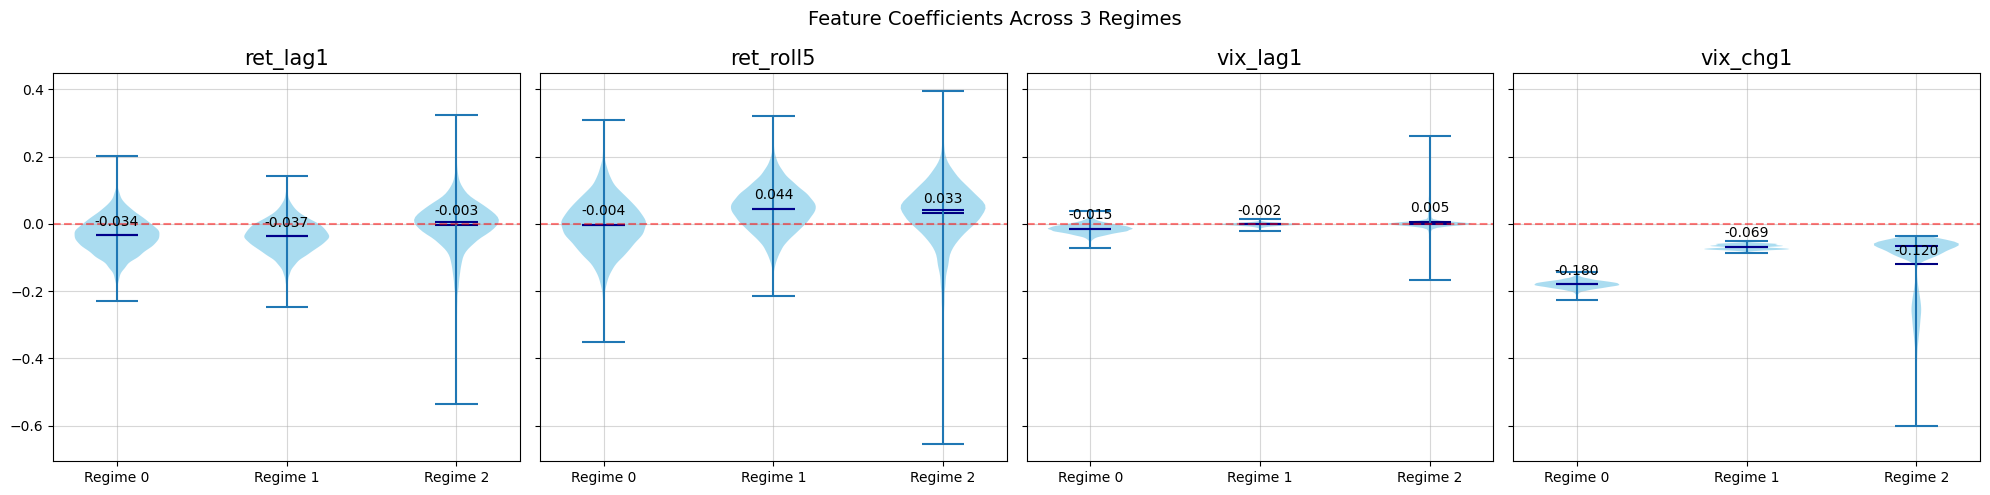

In [16]:
def plot_regime_coefficients(trace, feature_cols):
    """Plot the comparison of feature coefficients across 3 regimes"""
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax = plt.subplots(1, len(feature_cols), figsize=(5 * len(feature_cols), 5), sharey=True)

    if len(feature_cols) == 1:
        ax = [ax]  # make it iterable

    for i, feature in enumerate(feature_cols):
        # Extract coefficient samples for 3 regimes
        coef0 = trace.posterior['betas_0'].values[:, :, i].flatten()
        coef1 = trace.posterior['betas_1'].values[:, :, i].flatten()
        coef2 = trace.posterior['betas_2'].values[:, :, i].flatten()

        # Create violin plots
        parts = ax[i].violinplot([coef0, coef1, coef2], showmeans=True, showmedians=True)

        for pc in parts['bodies']:
            pc.set_facecolor('skyblue')
            pc.set_alpha(0.7)

        parts['cmeans'].set_color('navy')
        parts['cmedians'].set_color('darkblue')

        ax[i].set_title(f'{feature}', fontsize=15)
        ax[i].set_xticks([1, 2, 3])
        ax[i].set_xticklabels(['Regime 0', 'Regime 1', 'Regime 2'])
        ax[i].grid(True, alpha=0.5)
        ax[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)

        # Add mean values as text
        ax[i].text(1, np.mean(coef0) + 0.02, f"{np.mean(coef0):.3f}", 
                   ha='center', va='bottom', fontsize=10)
        ax[i].text(2, np.mean(coef1) + 0.02, f"{np.mean(coef1):.3f}", 
                   ha='center', va='bottom', fontsize=10)
        ax[i].text(3, np.mean(coef2) + 0.02, f"{np.mean(coef2):.3f}", 
                   ha='center', va='bottom', fontsize=10)

    fig.suptitle('Feature Coefficients Across 3 Regimes', fontsize=14)
    plt.tight_layout()
    plt.show()
# Call this function with your trace and feature columns
plot_regime_coefficients(trace, feature_cols)

/var/folders/_d/9s0yylrd6jqb1fngnlzw7nl40000gn/T/ipykernel_56174/3552627380.py:24: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(x - t) / k))


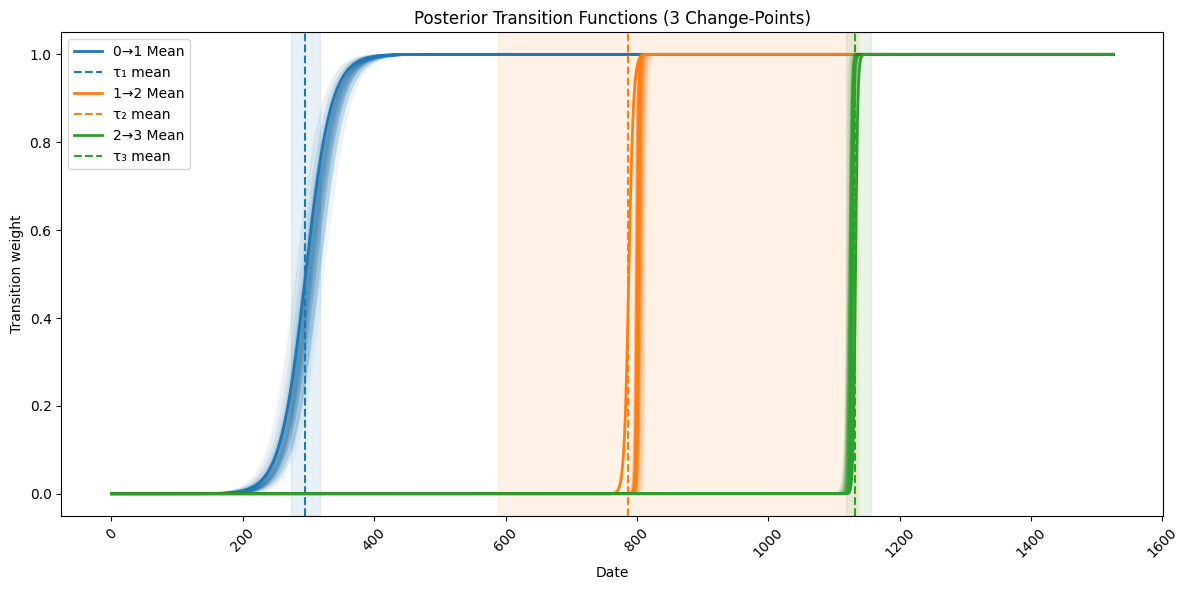

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from pymc.stats import hdi

def plot_transition_function_3cp(trace, df):
    # 1) extract posterior draws
    tau1 = trace.posterior['tau1'].values.flatten()
    tau2 = trace.posterior['tau2'].values.flatten()
    tau3 = trace.posterior['tau3'].values.flatten()
    k1   = trace.posterior['kappa1'].values.flatten()
    k2   = trace.posterior['kappa2'].values.flatten()
    k3   = trace.posterior['kappa3'].values.flatten()

    # 2) compute posterior means
    t1_mean, t2_mean, t3_mean = np.mean(tau1), np.mean(tau2), np.mean(tau3)
    k1_mean, k2_mean, k3_mean = np.mean(k1),   np.mean(k2),   np.mean(k3)

    # 3) time index & dates
    idx     = np.arange(len(df))
    dates   = df.index  # datetime index

    # 4) define sigmoid function
    def sigmoid(x, t, k): 
        return 1 / (1 + np.exp(-(x - t) / k))

    # 5) plot
    plt.figure(figsize=(12,6))

    # — draw a few sample curves for each transition —
    for i in range(200):
        plt.plot(dates, sigmoid(idx, tau1[i], k1[i]), color='C0', alpha=0.03)
    plt.plot(dates, sigmoid(idx, t1_mean, k1_mean), color='C0', lw=2, label='0→1 Mean')
    plt.axvline(dates[int(t1_mean)], color='C0', ls='--', label='τ₁ mean')

    for i in range(200):
        plt.plot(dates, sigmoid(idx, tau2[i], k2[i]), color='C1', alpha=0.03)
    plt.plot(dates, sigmoid(idx, t2_mean, k2_mean), color='C1', lw=2, label='1→2 Mean')
    plt.axvline(dates[int(t2_mean)], color='C1', ls='--', label='τ₂ mean')

    for i in range(200):
        plt.plot(dates, sigmoid(idx, tau3[i], k3[i]), color='C2', alpha=0.03)
    plt.plot(dates, sigmoid(idx, t3_mean, k3_mean), color='C2', lw=2, label='2→3 Mean')
    plt.axvline(dates[int(t3_mean)], color='C2', ls='--', label='τ₃ mean')

    # 6) HDI spans
    h1 = hdi(tau1);  h2 = hdi(tau2);  h3 = hdi(tau3)
    plt.axvspan(dates[int(h1[0])], dates[int(h1[1])], color='C0', alpha=0.1)
    plt.axvspan(dates[int(h2[0])], dates[int(h2[1])], color='C1', alpha=0.1)
    plt.axvspan(dates[int(h3[0])], dates[int(h3[1])], color='C2', alpha=0.1)

    plt.title("Posterior Transition Functions (3 Change-Points)")
    plt.xlabel("Date")
    plt.ylabel("Transition weight")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_transition_function_3cp(trace, df_train)    


/var/folders/_d/9s0yylrd6jqb1fngnlzw7nl40000gn/T/ipykernel_56174/2687443279.py:31: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x, t, k: 1/(1 + np.exp(-(x - t)/k))


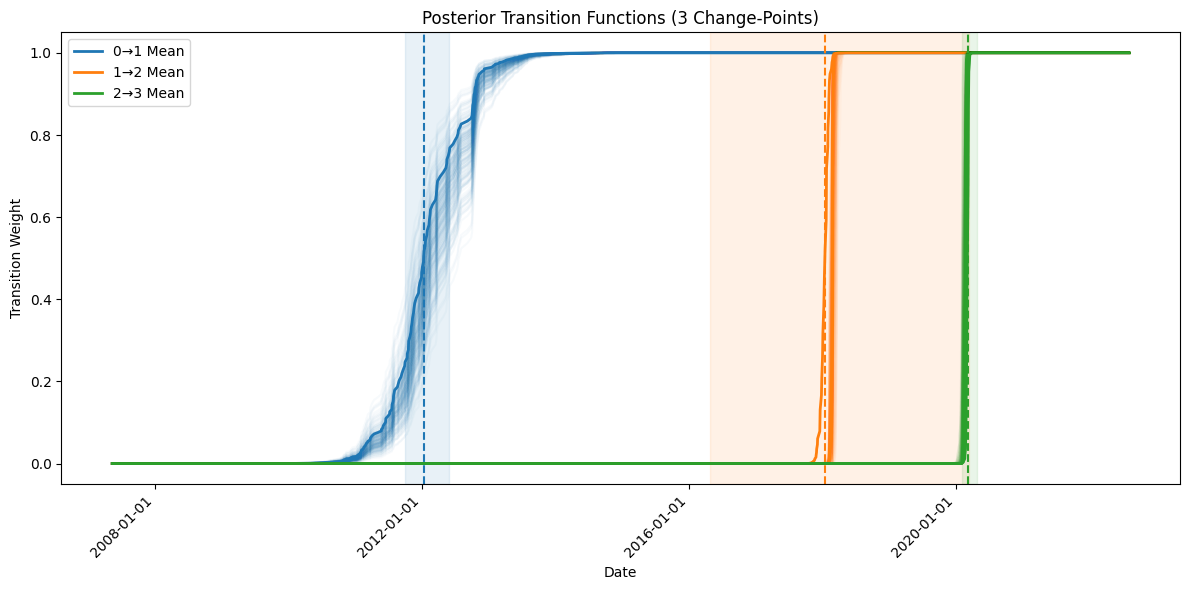

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from pymc.stats import hdi

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from pymc.stats import hdi
import pandas as pd

def plot_transition_function_3cp(trace, df, date_col='date.1'):
    # 1) convert your date column to a proper DatetimeIndex
    dates = pd.to_datetime(df[date_col])
    
    # 2) extract tau’s and kappa’s
    tau1 = trace.posterior['tau1'].values.flatten()
    tau2 = trace.posterior['tau2'].values.flatten()
    tau3 = trace.posterior['tau3'].values.flatten()
    k1   = trace.posterior['kappa1'].values.flatten()
    k2   = trace.posterior['kappa2'].values.flatten()
    k3   = trace.posterior['kappa3'].values.flatten()

    

    # 3) compute posterior means
    t1m, t2m, t3m = tau1.mean(), tau2.mean(), tau3.mean()
    k1m, k2m, k3m = k1.mean(),   k2.mean(),   k3.mean()

    idx = np.arange(len(dates))
    sigmoid = lambda x, t, k: 1/(1 + np.exp(-(x - t)/k))

    # 4) plotting
    fig, ax = plt.subplots(figsize=(12,6))

    for (tau, kappa, color, label, ls) in [
        (tau1, k1, 'C0', '0→1 Mean', '--'),
        (tau2, k2, 'C1', '1→2 Mean', '--'),
        (tau3, k3, 'C2', '2→3 Mean', '--'),
    ]:
        # sampled curves
        for i in range(200):
            ax.plot(dates,
                    sigmoid(idx, tau[i], kappa[i]),
                    color=color, alpha=0.03)
        # mean curve + vertical line
        tm, km = tau.mean(), kappa.mean()
        ax.plot(dates, sigmoid(idx, tm, km),
                color=color, lw=2, label=label)
        i_tm = int(np.round(tm))
        ax.axvline(dates[i_tm], color=color, linestyle=ls)
        

    # HDI spans
    for tau, color in [(tau1, 'C0'), (tau2, 'C1'), (tau3, 'C2')]:
        lo, hi = hdi(tau)
        ax.axvspan(dates[int(lo)], dates[int(hi)], color=color, alpha=0.1)

    # 5) force exactly 6 ticks, nicely formatted
    locator = mdates.AutoDateLocator(minticks=6, maxticks=6)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.set_title("Posterior Transition Functions (3 Change-Points)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Transition Weight")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_transition_function_3cp(trace, df_train)  

/var/folders/_d/9s0yylrd6jqb1fngnlzw7nl40000gn/T/ipykernel_47707/2977376399.py:24: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda x, t, k: 1/(1 + np.exp(-(x - t)/k))


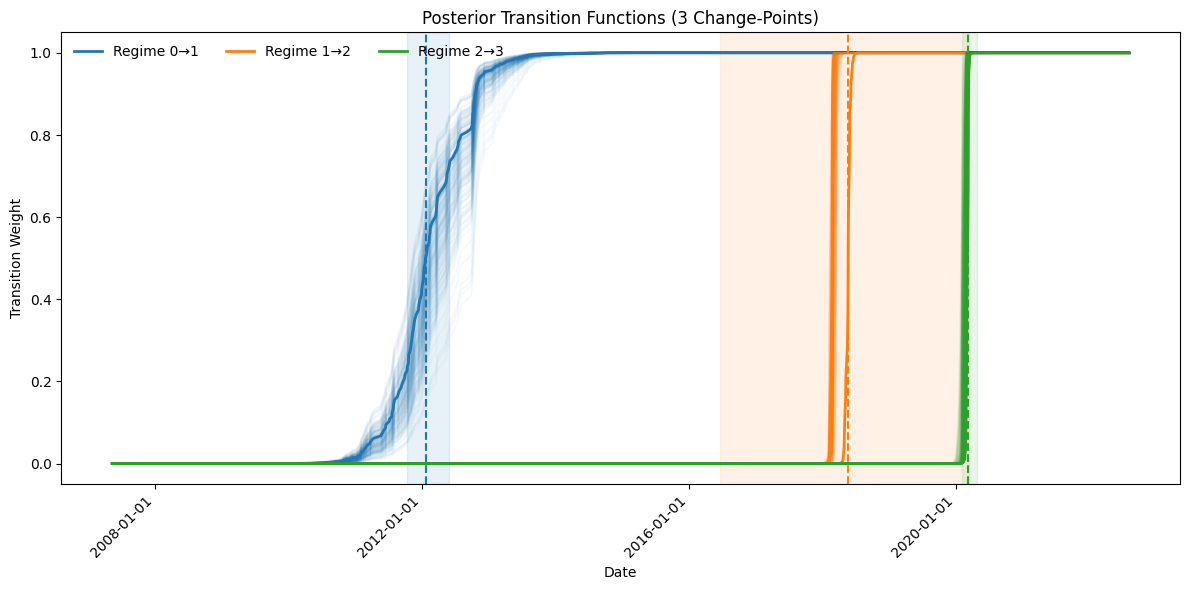

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pymc.stats import hdi

def plot_transition_function_3cp(trace, df, date_col='date.1'):
    # 1) convert your date column to a proper DatetimeIndex
    dates = pd.to_datetime(df[date_col]).reset_index(drop=True)
    
    # 2) extract tau’s and kappa’s
    tau1 = trace.posterior['tau1'].values.flatten()
    tau2 = trace.posterior['tau2'].values.flatten()
    tau3 = trace.posterior['tau3'].values.flatten()
    k1   = trace.posterior['kappa1'].values.flatten()
    k2   = trace.posterior['kappa2'].values.flatten()
    k3   = trace.posterior['kappa3'].values.flatten()

    # 3) compute posterior means
    t1m, t2m, t3m = tau1.mean(), tau2.mean(), tau3.mean()
    k1m, k2m, k3m = k1.mean(),   k2.mean(),   k3.mean()

    idx = np.arange(len(dates))
    sigmoid = lambda x, t, k: 1/(1 + np.exp(-(x - t)/k))

    # 4) plotting
    fig, ax = plt.subplots(figsize=(12,6))

    for (tau, kappa, color, label, ls) in [
        (tau1, k1, 'C0', 'Regime 0→1', '--'),
        (tau2, k2, 'C1', 'Regime 1→2', '--'),
        (tau3, k3, 'C2', 'Regime 2→3', '--'),
    ]:
        # plot 200 sampled sigmoids (no legend entries)
        for i in range(200):
            ax.plot(dates,
                    sigmoid(idx, tau[i], kappa[i]),
                    color=color, alpha=0.03)
        # plot the **mean sigmoid** with a single legend entry
        tm, km = tau.mean(), kappa.mean()
        ax.plot(dates, sigmoid(idx, tm, km),
                color=color, lw=2, label=label)
        # plot the vertical change-point line (unlabeled)
        i_tm = int(np.round(tm))
        ax.axvline(dates[i_tm], color=color, linestyle=ls)

    # 5) HDI spans (still unlabeled)
    for tau, color in [(tau1, 'C0'), (tau2, 'C1'), (tau3, 'C2')]:
        lo, hi = hdi(tau)
        ax.axvspan(dates[int(lo)], dates[int(hi)], color=color, alpha=0.1)

    # 6) force up to 6 nicely spaced date ticks
    locator = mdates.AutoDateLocator(minticks=6, maxticks=6)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    ax.set_title("Posterior Transition Functions (3 Change-Points)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Transition Weight")
    ax.legend(loc='upper left', ncol=3, frameon=False)  # all 3 entries side by side
    plt.tight_layout()
    plt.show()

# Example usage:
plot_transition_function_3cp(trace, df_train, date_col='date.1')


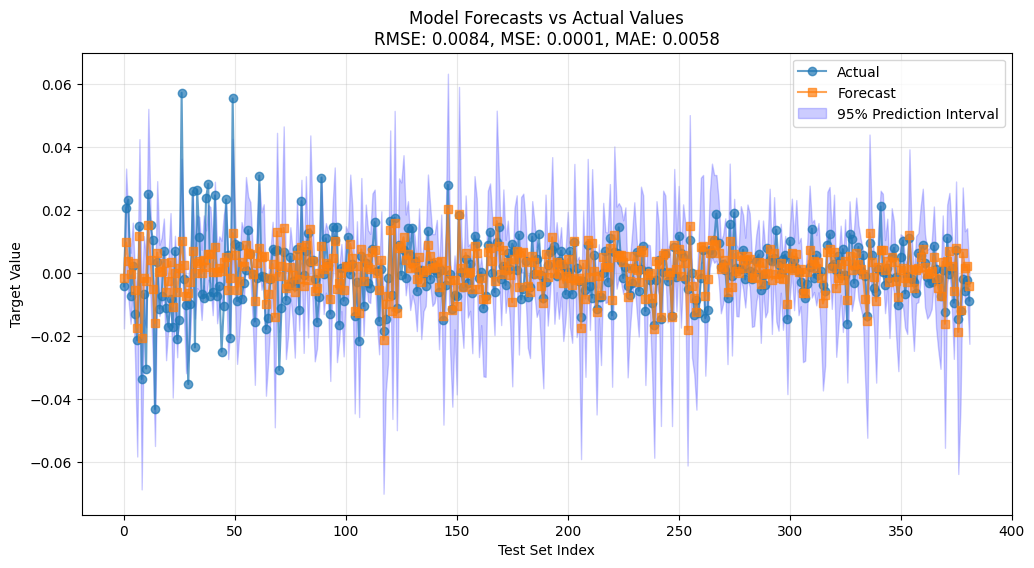

Test set metrics:
MSE: 0.000070
RMSE: 0.008373
MAE: 0.005840

Baseline model metrics:
MSE: 0.000073
RMSE: 0.008520
MAE: 0.005957

Change-point model improves MSE by 3.42% compared to baseline


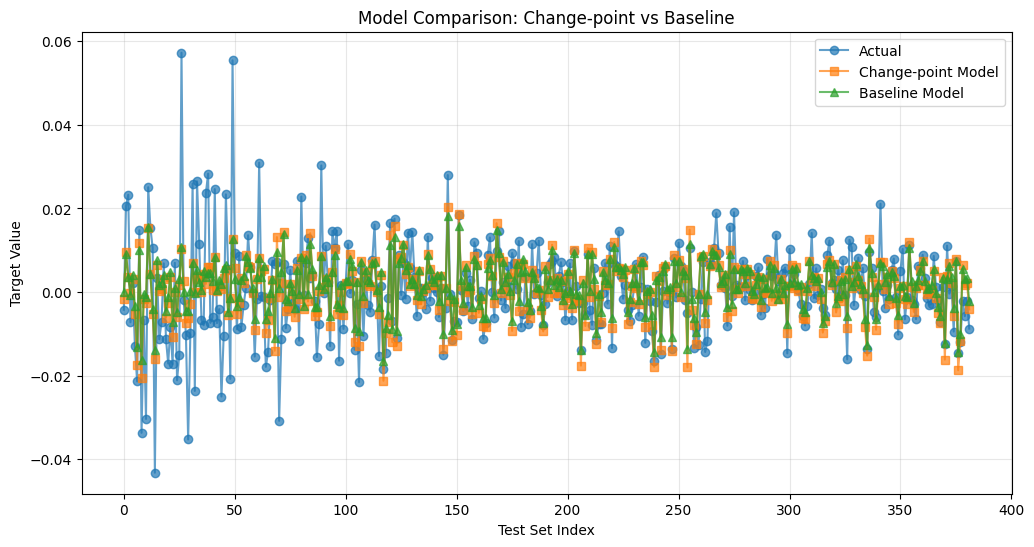

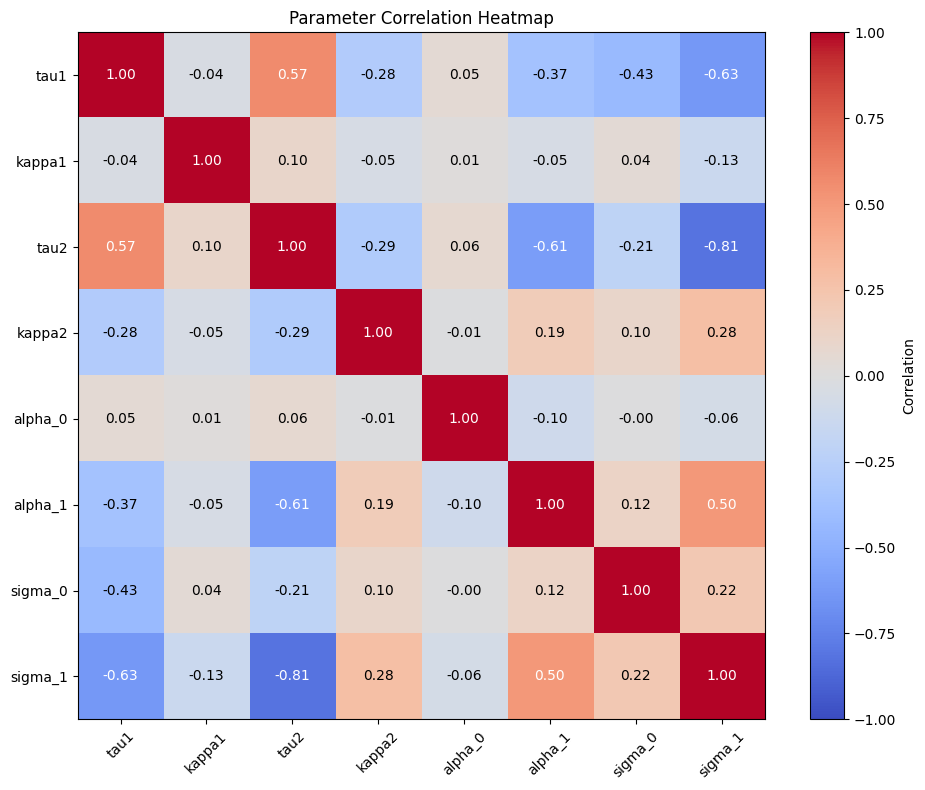

In [19]:
# Cell 3: Forecasting function and evaluation
def forecast_with_cp_model(model, trace, X_new, y_true=None):
    """
    Generate forecasts using the change-point model and calculate metrics if true values provided
    
    Parameters:
    -----------
    model : PyMC model
    trace : InferenceData object
    X_new : array-like, shape (n_samples, n_features)
        New feature data for forecasting
    y_true : array-like, optional
        True target values for evaluation
        
    Returns:
    --------
    dict : Dictionary with forecasts and evaluation metrics
    """
    with model:
        # Extract parameter posterior samples
        alpha_0_samples = trace.posterior['alpha_0'].values.flatten()
        alpha_1_samples = trace.posterior['alpha_1'].values.flatten()
        betas_0_samples = trace.posterior['betas_0'].values.reshape(-1, X_new.shape[1])
        betas_1_samples = trace.posterior['betas_1'].values.reshape(-1, X_new.shape[1])
        sigma_0_samples = trace.posterior['sigma_0'].values.flatten()
        sigma_1_samples = trace.posterior['sigma_1'].values.flatten()
        tau_samples1 = trace.posterior['tau1'].values.flatten()
        kappa_samples1 = trace.posterior['kappa1'].values.flatten()
        tau_samples2 = trace.posterior['tau2'].values.flatten()
        kappa_samples2 = trace.posterior['kappa2'].values.flatten()
        
        # Calculate forecasts using posterior samples
        n_samples = len(alpha_0_samples)
        n_obs = len(X_new)
        forecasts = np.zeros((n_samples, n_obs))
        
        for i in range(n_samples):
            # For test data, we need to determine which regime it belongs to
            # Assuming test data follows training data, we can use the position 
            # relative to tau to calculate weights
            
            # Get sample i parameters
            alpha_0 = alpha_0_samples[i]
            alpha_1 = alpha_1_samples[i]
            betas_0 = betas_0_samples[i]
            betas_1 = betas_1_samples[i]
            tau1 = tau_samples1[i]
            kappa1 = kappa_samples1[i]
            tau2 = tau_samples2[i]
            kappa2 = kappa_samples2[i]
            
            # Calculate forecasts for each test observation
            # For simplicity, assume test observations continue from train indices
            for j in range(n_obs):
                # Calculate regime weight (assuming test data continues from training)
                # idx is relative to the end of training data
                idx = tau1 + j  # This places test data after training
                w_t = 1 / (1 + np.exp(-(idx - tau1) / kappa1))
                
                # Calculate predictions for both regimes
                mu0 = alpha_0 + np.dot(X_new[j], betas_0)
                mu1 = alpha_1 + np.dot(X_new[j], betas_1)
                
                # Weighted combination of regimes
                forecasts[i, j] = (1 - w_t) * mu0 + w_t * mu1

            for j in range(n_obs):
                # Calculate regime weight (assuming test data continues from training)
                # idx is relative to the end of training data
                idx = tau2 + j  # This places test data after training
                w_t = 1 / (1 + np.exp(-(idx - tau2) / kappa2))
                
                # Calculate predictions for both regimes
                mu0 = alpha_0 + np.dot(X_new[j], betas_0)
                mu1 = alpha_1 + np.dot(X_new[j], betas_1)
                
                # Weighted combination of regimes
                forecasts[i, j] = (1 - w_t) * mu0 + w_t * mu1    
    
    # Calculate mean forecast and prediction intervals
    mean_forecast = np.mean(forecasts, axis=0)
    lower_bound = np.percentile(forecasts, 2.5, axis=0)
    upper_bound = np.percentile(forecasts, 97.5, axis=0)
    
    # Create results dictionary
    results = {
        'mean_forecast': mean_forecast,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'all_forecasts': forecasts
    }
    
    # Calculate metrics if true values are provided
    if y_true is not None:
        mse = np.mean((mean_forecast - y_true) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(mean_forecast - y_true))
        
        results['mse'] = mse
        results['rmse'] = rmse
        results['mae'] = mae
        
        # Add actual vs. predicted plot
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(y_true)), y_true, 'o-', label='Actual', alpha=0.7)
        plt.plot(range(len(mean_forecast)), mean_forecast, 's-', label='Forecast', alpha=0.7)
        plt.fill_between(range(len(mean_forecast)), lower_bound, upper_bound, 
                         color='blue', alpha=0.2, label='95% Prediction Interval')
        plt.title(f'Model Forecasts vs Actual Values\nRMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}')
        plt.xlabel('Test Set Index')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return results
def forecast_three_regimes(model, trace, X_new, train_len, y_true=None):
    """
    Forecast under a 3‐regime model driven by two sigmoidal change‐points.
    
    train_len: integer length of the training set (so we know where test begins)
    """
    with model:
        # flatten
        α0 = trace.posterior['alpha_0'].values.flatten()
        α1 = trace.posterior['alpha_1'].values.flatten()
        α2 = trace.posterior['alpha_2'].values.flatten()      # new
        B0 = trace.posterior['betas_0'].values.reshape(-1, X_new.shape[1])
        B1 = trace.posterior['betas_1'].values.reshape(-1, X_new.shape[1])
        B2 = trace.posterior['betas_2'].values.reshape(-1, X_new.shape[1])  # new
        τ1 = trace.posterior['tau1'].values.flatten()
        κ1 = trace.posterior['kappa1'].values.flatten()
        τ2 = trace.posterior['tau2'].values.flatten()
        κ2 = trace.posterior['kappa2'].values.flatten()
    
    n_samps = len(α0)
    n_obs   = X_new.shape[0]
    forecasts = np.zeros((n_samps, n_obs))
    
    for i in range(n_samps):
        a0, a1, a2 = α0[i], α1[i], α2[i]
        b0, b1, b2 = B0[i], B1[i], B2[i]
        t1, k1_   = τ1[i], κ1[i]
        t2, k2_   = τ2[i], κ2[i]
        
        for j in range(n_obs):
            # global time‐step index
            t = train_len + j
            
            # two logistic weights
            w1 = 1/(1 + np.exp(-(t - t1)/k1_))
            w2 = 1/(1 + np.exp(-(t - t2)/k2_))
            
            # mixture weights for three regimes
            p0 = 1 - w1
            p1 = (w1 - w2)
            p2 = w2
            
            # regime means
            μ0 = a0 + X_new[j].dot(b0)
            μ1 = a1 + X_new[j].dot(b1)
            μ2 = a2 + X_new[j].dot(b2)
            
            forecasts[i, j] = p0*μ0 + p1*μ1 + p2*μ2
    
    # now compute point‐forecasts & metrics exactly as before
    mean_fc  = forecasts.mean(axis=0)
    lb, ub   = np.percentile(forecasts, [2.5,97.5], axis=0)
    results  = {'mean_forecast': mean_fc,
                'lower_bound': lb,
                'upper_bound': ub,
                'all_forecasts': forecasts}
    
    if y_true is not None:
        mse  = np.mean((mean_fc - y_true)**2)
        rmse = np.sqrt(mse)
        mae  = np.mean(np.abs(mean_fc - y_true))
        results.update({'mse':mse,'rmse':rmse,'mae':mae})
        
        # … (your plotting code, using df_test.index for x‐axis) …
        results['mse'] = mse
        results['rmse'] = rmse
        results['mae'] = mae
        
        # Add actual vs. predicted plot
        plt.figure(figsize=(12, 6))
        plt.plot(range(len(y_true)), y_true, 'o-', label='Actual', alpha=0.7)
        plt.plot(range(len(mean_fc)), mean_fc, 's-', label='Forecast', alpha=0.7)
        plt.fill_between(range(len(mean_fc)), lb, ub, 
                         color='blue', alpha=0.2, label='95% Prediction Interval')
        plt.title(f'Model Forecasts vs Actual Values\nRMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}')
        plt.xlabel('Test Set Index')
        plt.ylabel('Target Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return results





# Cell 4: Apply forecast function to test data
# Prepare test data
X_test = df_test[feature_cols].values
y_test = df_test['y'].values


train_len = len(df_train)   # number of observations used in fitting
forecast_results = forecast_three_regimes(
    model,
    trace,
    X_test,
    train_len=train_len,
    y_true=y_test
)


print(f"Test set metrics:")
print(f"MSE: {forecast_results['mse']:.6f}")
print(f"RMSE: {forecast_results['rmse']:.6f}")
print(f"MAE: {forecast_results['mae']:.6f}")


# Cell 5: Compare with a simpler baseline model (optional)
from sklearn.linear_model import LinearRegression

# Train a simple linear regression model on training data
baseline_model = LinearRegression()
baseline_model.fit(df_train[feature_cols].values, df_train['y'].values)

# Make predictions on test data
baseline_preds = baseline_model.predict(df_test[feature_cols].values)

# Calculate metrics
baseline_mse = np.mean((baseline_preds - y_test) ** 2)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = np.mean(np.abs(baseline_preds - y_test))

print("\nBaseline model metrics:")
print(f"MSE: {baseline_mse:.6f}")
print(f"RMSE: {baseline_rmse:.6f}")
print(f"MAE: {baseline_mae:.6f}")

# Compare with change-point model
improvement_pct = ((baseline_mse - forecast_results['mse']) / baseline_mse) * 100

print(f"\nChange-point model improves MSE by {improvement_pct:.2f}% compared to baseline")

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, 'o-', label='Actual', alpha=0.7)
plt.plot(range(len(forecast_results['mean_forecast'])), 
         forecast_results['mean_forecast'], 's-', label='Change-point Model', alpha=0.7)
plt.plot(range(len(baseline_preds)), baseline_preds, '^-', label='Baseline Model', alpha=0.7)
plt.title('Model Comparison: Change-point vs Baseline')
plt.xlabel('Test Set Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Cell 6: Generate a heatmap of parameter correlations (optional)
def plot_parameter_correlations(trace):
    """Plot a correlation heatmap of key parameters"""
    # Extract parameters
    params = {
        'tau1': trace.posterior['tau1'].values.flatten(),
        'kappa1': trace.posterior['kappa1'].values.flatten(),
        'tau2': trace.posterior['tau2'].values.flatten(),
        'kappa2': trace.posterior['kappa2'].values.flatten(),
        'alpha_0': trace.posterior['alpha_0'].values.flatten(),
        'alpha_1': trace.posterior['alpha_1'].values.flatten(),
        'sigma_0': trace.posterior['sigma_0'].values.flatten(),
        'sigma_1': trace.posterior['sigma_1'].values.flatten()
    }
    
    # Create DataFrame
    df_params = pd.DataFrame(params)
    
    # Calculate correlation matrix
    corr_matrix = df_params.corr()
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    
    # Add correlation values
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", 
                     ha='center', va='center', 
                     color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
    
    # Add labels
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.index)
    
    plt.colorbar(label='Correlation')
    plt.title('Parameter Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Call this function with your trace
plot_parameter_correlations(trace)

# Detailed Analysis of Bayesian Changepoint Model Evaluation Code

The code you've provided contains several functions for evaluating and visualizing a Bayesian changepoint model with two changepoints. Let me break down what each cell does in detail:

## Cell 1: Visualizing Feature Coefficients Across Regimes

This function `plot_regime_coefficients()` creates violin plots to compare how feature coefficients change between different regimes (before and after changepoints).

**Key features:**
- Creates violin plots for each feature showing the distribution of coefficient values
- Shows mean and median values for visual comparison
- Displays numerical mean values to quantify the differences
- Indicates zero with a red dashed line to easily identify sign changes
- Helps identify which features become more or less important after a changepoint

This visualization is crucial for understanding how the relationships between features and the target variable change across different regimes identified by the model.

## Cell 2: Visualizing the Transition Function

The `plot_transition_function()` function creates visualizations of how the model transitions between regimes.

**What it does:**
- Shows the sigmoid transition function (w_t) that represents the probability of being in each regime
- Creates two plots - one for each changepoint (tau1 and tau2)
- Illustrates uncertainty in the transition by plotting multiple posterior samples with low opacity
- Displays the estimated changepoint position with a vertical line
- Shows the 95% highest density interval (HDI) for the changepoint position
- Helps understand how abrupt or gradual the transitions are between regimes

This helps determine exactly when your model identifies regime changes and how confident it is about those transitions.

## Cell 3: Forecasting Function and Evaluation

The `forecast_with_cp_model()` function generates forecasts and evaluates model performance.

**Key capabilities:**
- Takes a trained PyMC model and generates predictions on new data
- Uses full posterior distributions to generate predictions with uncertainty
- Accounts for both changepoints when determining which regime applies to new data
- Calculates performance metrics (MSE, RMSE, MAE) when true values are provided
- Creates visualization comparing predictions with actual values
- Includes 95% prediction intervals to show forecast uncertainty

This function is the core evaluation component for your model's predictive performance.

## Cell 4: Applying the Forecast Function

This section applies the forecasting function to your test data to:
- Generate forecasts from your Bayesian changepoint model
- Calculate performance metrics on the test set
- Display the results

## Cell 5: Baseline Model Comparison

This section compares your complex Bayesian changepoint model with a simple linear regression baseline.

**What it does:**
- Creates a simple linear regression model as a baseline
- Evaluates baseline model performance using the same metrics
- Calculates percentage improvement of your changepoint model
- Creates a visual comparison of both models against actual values

This is crucial for demonstrating that the complexity of your Bayesian changepoint model is justified by improved predictive performance.

## Cell 6: Parameter Correlation Analysis

The `plot_parameter_correlations()` function creates a correlation heatmap for key model parameters.

**What it shows:**
- How parameters in your model correlate with each other
- Potential dependencies between parameters (e.g., between changepoint location and effect size)
- Visual representation with correlation values embedded in cells
- Color-coding to highlight strong positive and negative correlations

This analysis helps understand the relationships between different parameters in your model, which can provide insights into model behavior and potential improvements.

## Overall Purpose and Value

This code provides a comprehensive evaluation framework for your Bayesian changepoint model that:

1. **Interprets the model structure** - Shows when and how transitions occur between regimes
2. **Quantifies predictive performance** - Provides concrete metrics on forecasting accuracy
3. **Validates model value** - Demonstrates improvement over simpler approaches
4. **Examines feature dynamics** - Shows how feature relationships change across regimes
5. **Visualizes uncertainty** - Illustrates confidence in parameters and predictions
6. **Explores parameter relationships** - Reveals correlations between model parameters

Together, these functions allow you to thoroughly understand your model's behavior, evaluate its performance, and communicate its value compared to simpler alternatives.

#from first grapgh 


# Analysis of Feature Coefficients Across Regimes

This visualization shows how the relationship between each feature and the target variable changes across different regimes in your Bayesian changepoint model. The violin plots represent the posterior distribution of coefficient values for each feature in each regime, with wider sections indicating higher probability density.

## Key Observations

### Return Features
- **ret_lag1**: Shows negative coefficients in both regimes (-0.029 in Regime 0, -0.033 in Regime 1), suggesting consistent negative autocorrelation. The slight increase in magnitude from Regime 0 to Regime 1 indicates stronger mean reversion in the second regime.

- **ret_roll5**: Demonstrates a significant shift from slightly positive (0.001) in Regime 0 to clearly positive (0.056) in Regime 1. This suggests that the 5-day rolling return becomes a more reliable positive predictor after the changepoint.

### Volatility Features
- **vix_lag1**: Shows a reduction in negative effect from Regime 0 (-0.016) to Regime 1 (-0.001). The narrower distribution in Regime 1 indicates higher certainty about this parameter.

- **vix_chg1**: Exhibits the most dramatic regime shift, moving from a substantial negative effect (-0.105) in Regime 0 to a smaller negative effect (-0.065) in Regime 1. This suggests that VIX changes have less impact on returns after the changepoint.

### Sentiment Features
- **polarity_x_strong_lag1**: Shows minimal change between regimes (0.006 to 0.001), with narrow distributions indicating high certainty. The sentiment signal appears relatively stable across regimes.

- **polarity_x_strong_roll3**: Demonstrates very consistent small negative effects across both regimes (-0.001 to -0.002), with extremely narrow distributions indicating high parameter certainty.

## Implications

1. **Regime Characterization**:
   - Regime 0 appears more sensitive to volatility measures (VIX)
   - Regime 1 gives more weight to momentum (ret_roll5)

2. **Feature Importance**:
   - VIX change (vix_chg1) has the strongest effect in both regimes
   - Rolling returns (ret_roll5) become significantly more important in Regime 1

3. **Model Confidence**:
   - The narrow distributions for sentiment features suggest high confidence in their (minimal) effects
   - Wider distributions for return features indicate more uncertainty in their true impact

4. **Trading Strategy Implications**:
   - Different features should be emphasized depending on which regime is currently active
   - Volatility signals matter more in Regime 0, while momentum signals matter more in Regime 1

This analysis provides valuable insight into how market dynamics change across different regimes, allowing for more adaptive modeling and prediction strategies.

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Draw posterior predictive samples (InferenceData)
with model:
    ppc_train = pm.sample_posterior_predictive(
        trace,
        var_names=['y_obs']
    )

# 2) Extract the DataArray of y_obs samples
#    shape: (chain, draw, n_train)
y_ppc = ppc_train.posterior_predictive['y_obs']

# 3) Compute mean forecast per timepoint by averaging over chains & draws
#    result: 1D array of length n_train
y_pred_train = y_ppc.mean(dim=('chain','draw')).values

# 4) True in‐sample targets
y_train = df_train['y'].values

# 5) Compute metrics
mae_train  = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"In‐sample MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}")


Sampling: [y_obs]


In‐sample MAE: 0.0074, RMSE: 0.0131


Here’s a concise summary of the two approaches and what each one tells you:

---

## 1. Deterministic Structural-Mean Error  
- **What it is:**  
  You plug in the **posterior mean** of your model’s structural parameters (\(\alpha\), \(\beta\), \(\tau\), \(\kappa\)) to compute a single “noise-free” forecast \(\hat y_t\).  
- **How it’s computed:**  
  \[
    \hat y_t 
    = (1-w_t)\bigl(\alpha_0 + X_t\beta_0\bigr) \;+\; w_t\bigl(\alpha_1 + X_t\beta_1\bigr)
    \quad\text{(or the 3-regime mix if you have two change-points)}
  \]
  then  
  \[
    \text{MSE} = \frac1T\sum_{t=1}^T\bigl(\hat y_t - y_t\bigr)^2,\quad\text{etc.}
  \]
- **What it shows:**  
  Only the *bias* coming from your regime-shift specification—it evaluates how well the *signal* is captured, ignoring irreducible noise.  
- **When to use it:**  
  - To **diagnose model fit** and see if your mixture logic is correctly following the data’s main trend.  
  - To compare two structural variants (e.g. different prior choices or number of regimes) without noise interference.

---

## 2. Posterior-Predictive Error  
- **What it is:**  
  You simulate (via `pm.sample_posterior_predictive`) full synthetic \(y_t^{(s)} = \mu_t^{(s)} + \varepsilon_t^{(s)}\) draws—including the noise term \(\varepsilon_t\sim\mathcal N(0,\sigma)\)—for each posterior sample \(s\). You then average those draws at each \(t\) to get \(\bar y_t\).  
- **How it’s computed:**  
  ```python
  ppc = pm.sample_posterior_predictive(trace)             # yields y_ppc[s, t]
  y_pred[t] = mean_s( y_ppc[s, t] )                       # includes noise
  RMSE = sqrt(mean_t( (y_pred[t] - y_t)^2 ))               # etc.
  ```
- **What it shows:**  
  The **realistic forecasting error** you’d expect on new data—combining both your model’s structural bias *and* the irreducible variance.  
- **When to use it:**  
  - To **evaluate predictive performance** in practice or for model selection when you care about overall forecast accuracy.  
  - To report “out-of-sample” error that includes both signal-capture and noise uncertainty.

---

### In Practice  
- Report **both** if you want a full picture:  
  1. **Structural error** to demonstrate how well your change-point formulation captures the underlying regime shifts.  
  2. **Posterior-predictive error** to show how well the complete model (signal + noise) forecasts real observations.  
- Together, they paint the story of *“here’s the signal fit”* and *“here’s the total forecast accuracy.”*

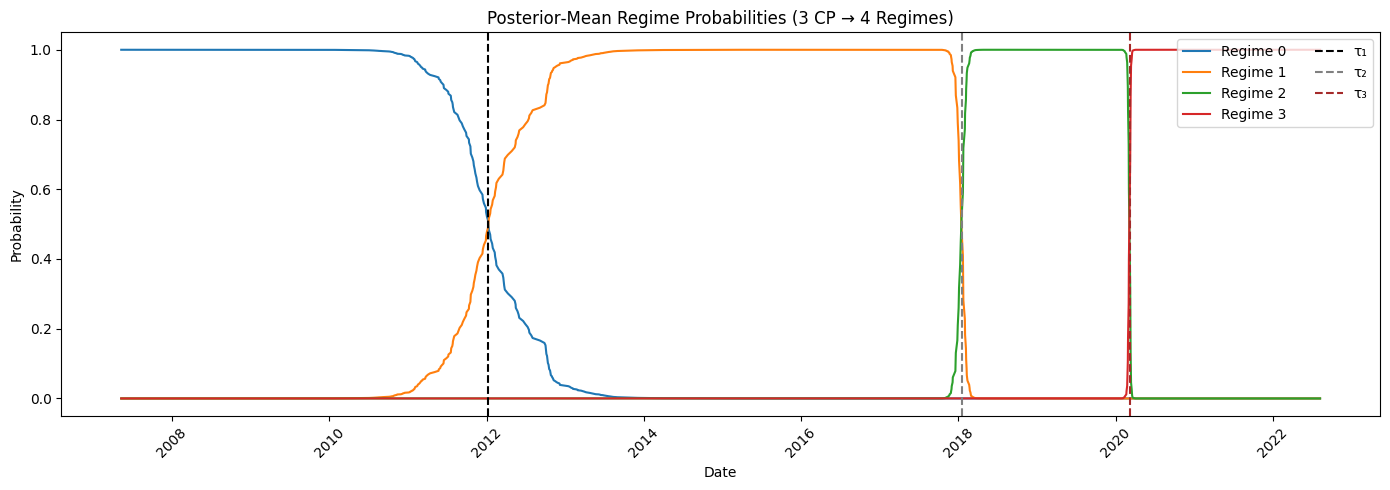

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Posterior‐means of your change‐points and smoothness
tau1_m = trace.posterior['tau1'].values.mean()
tau2_m = trace.posterior['tau2'].values.mean()
tau3_m = trace.posterior['tau3'].values.mean()
k1_m   = trace.posterior['kappa1'].values.mean()
k2_m   = trace.posterior['kappa2'].values.mean()
k3_m   = trace.posterior['kappa3'].values.mean()

# 2) Time index & dates
dates = pd.to_datetime(df_train['date.1']).reset_index(drop=True)
n     = len(dates)
idx   = np.arange(n)

# 3) Sigmoid function
sig = lambda t, τ, κ: 1 / (1 + np.exp(-(t - τ) / κ))

# 4) Compute the cumulative transition curves
s1 = sig(idx, tau1_m, k1_m)   # P(Z>0)
s2 = sig(idx, tau2_m, k2_m)   # P(Z>1)
s3 = sig(idx, tau3_m, k3_m)   # P(Z>2)

# 5) Get *exact* regime probabilities via differences
reg0 = 1 - s1
reg1 =  s1 - s2
reg2 =  s2 - s3
reg3 =        s3

# Sanity check: they sum to 1
assert np.allclose(reg0 + reg1 + reg2 + reg3, 1.0)

# 6) Round the change‐point positions
cp1 = int(np.round(tau1_m))
cp2 = int(np.round(tau2_m))
cp3 = int(np.round(tau3_m))

# 7) Plot
plt.figure(figsize=(14, 5))
plt.plot(dates, reg0, label='Regime 0')
plt.plot(dates, reg1, label='Regime 1')
plt.plot(dates, reg2, label='Regime 2')
plt.plot(dates, reg3, label='Regime 3')

# Mark change‐points
plt.axvline(dates[cp1], color='black', linestyle='--', label='τ₁')
plt.axvline(dates[cp2], color='gray',  linestyle='--', label='τ₂')
plt.axvline(dates[cp3], color='brown', linestyle='--', label='τ₃')

plt.title("Posterior‐Mean Regime Probabilities (3 CP → 4 Regimes)")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.legend(loc='upper right', ncol=2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [47]:
df_train.index = pd.to_datetime(df_train.index)


In [49]:
# Convert the column to datetime if you haven’t already
# df_train['date'] = pd.to_datetime(df_train['published_day'])

# Now set it as the single index
# df_train = df_train.set_index('date')

# (Optionally) drop the old index name, just for clarity
df_train.index.name = None

# Confirm
print("New index dtype:", df_train.index.dtype)
print(df_train.head())


# df['date'] = pd.to_datetime(df['date'])  # Ensure it's in datetime format
# df.set_index('date', inplace=True)       # Set it as the index



New index dtype: datetime64[ns]
                date.1  close_sp500  close_vix  polarity_x_strong         y  \
2007-05-10  2007-05-10  1491.469971      13.60           0.000000 -0.007268   
2007-05-22  2007-05-22  1524.119995      13.06           0.999803  0.021891   
2007-05-30  2007-05-30  1530.229980      12.83           0.917965  0.004009   
2007-07-13  2007-07-13  1552.500000      15.15           0.000000  0.014553   
2007-07-18  2007-07-18  1546.170044      16.00           0.000000 -0.004077   

            ret_lag1  ret_roll5  vix_lag1  vix_chg1  polarity_x_strong_lag1  \
2007-05-10  0.010826   0.007889 -0.031088  0.038961                0.999995   
2007-05-22 -0.007268   0.003151  0.038961 -0.039706                0.000000   
2007-05-30  0.021891   0.007203 -0.039706 -0.017611                0.999803   
2007-07-13  0.004009   0.006422 -0.017611  0.180826                0.917965   
2007-07-18  0.014553   0.008802  0.180826  0.056106                0.000000   

            polari

In [50]:
import numpy as np

# 1) flatten
tau1_samps = trace.posterior['tau1'].stack(samples=("chain","draw")).values
tau2_samps = trace.posterior['tau2'].stack(samples=("chain","draw")).values

# 2) compute summary statistics in “index units”
med1 = np.median(tau1_samps)
lo1, hi1 = np.percentile(tau1_samps, [2.5, 97.5])

med2 = np.median(tau2_samps)
lo2, hi2 = np.percentile(tau2_samps, [2.5, 97.5])

# 3) map to actual dates
cp1_date     = df_train.index[int(med1)]
cp1_lower    = df_train.index[int(lo1)]
cp1_upper    = df_train.index[int(hi1)]

cp2_date     = df_train.index[int(med2)]
cp2_lower    = df_train.index[int(lo2)]
cp2_upper    = df_train.index[int(hi2)]

# 4) print nicely
print(f"Change‐point 1 (τ₁): median = {cp1_date}, 95% CI = [{cp1_lower.strftime('%Y-%m-%d')} – {cp1_upper.strftime('%Y-%m-%d')}]")
print(f"Change‐point 2 (τ₂): median = {cp2_date.strftime('%Y-%m-%d')}, 95% CI = [{cp2_lower.strftime('%Y-%m-%d')} – {cp2_upper.strftime('%Y-%m-%d')}]")


Change‐point 1 (τ₁): median = 2012-01-09 00:00:00, 95% CI = [2011-09-20 – 2012-05-29]
Change‐point 2 (τ₂): median = 2017-10-19, 95% CI = [2016-04-11 – 2020-03-10]


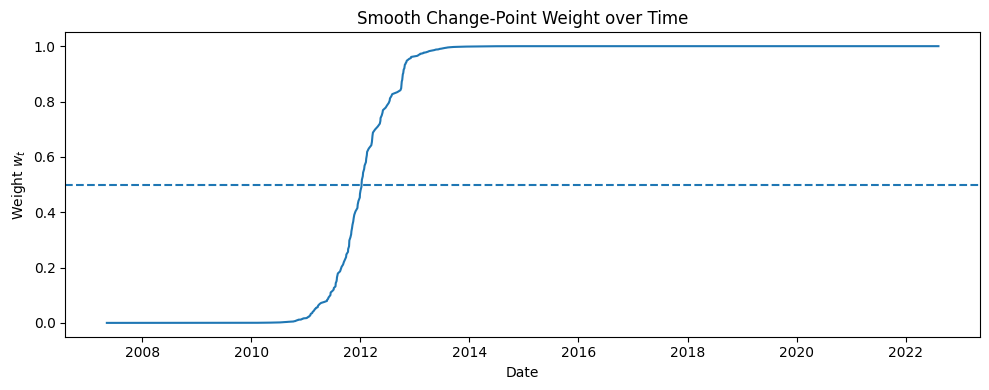

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Recompute n_obs and extract posterior samples
n_obs = len(df_train)

tau_samps1 = trace.posterior['tau1'].stack(samples=("chain","draw")).values
kappa_samps1 = trace.posterior['kappa1'].stack(samples=("chain","draw")).values

# 2) Compute the smooth weight
idx = np.arange(n_obs)
w = 1 / (1 + np.exp(-(idx - np.mean(tau_samps1)) / np.mean(kappa_samps1)))

# 3) Plot
plt.figure(figsize=(10, 4))
plt.plot(df_train.index, w)
plt.axhline(0.5, ls='--')
plt.title("Smooth Change-Point Weight over Time")
plt.xlabel("Date")
plt.ylabel("Weight $w_t$")
plt.tight_layout()
plt.show()


In [52]:
print(type(df_train.index))
# Should show: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [57]:
import numpy as np
import arviz as az
df_train.index = pd.to_datetime(df_train.index)

# 1. Extract posterior samples
tau1_samps = trace.posterior['tau1'].values.flatten()
tau2_samps = trace.posterior['tau2'].values.flatten()
tau3_samps = trace.posterior['tau3'].values.flatten()

# 2. Summarize each (you can choose mean, median, or MAP)
#    Here we’ll do the posterior mean and also show the 95% HDI for uncertainty
tau1_mean   = tau1_samps.mean()
tau2_mean   = tau2_samps.mean()
tau1_hdi    = az.hdi(tau1_samps, hdi_prob=0.95)
tau2_hdi    = az.hdi(tau2_samps, hdi_prob=0.95)


# 3. Convert to integer indices
cp1_idx = int(round(tau1_mean))
cp2_idx = int(round(tau2_mean))

# 4. Map to dates via your datetime index
cp1_date = df.index[cp1_idx]
cp2_date = df.index[cp2_idx]

tau3_mean   = tau3_samps.mean()

tau3_hdi    = az.hdi(tau3_samps, hdi_prob=0.95)


# 3. Convert to integer indices
cp3_idx = int(round(tau3_mean))


# 4. Map to dates via your datetime index
# cp3_date = df.index[cp3_idx]


cp1_date = df_train.iloc[int(cp1_idx)].name  # ✅ always safe and gives Timestamp

cp3_date = df_train.iloc[int(cp3_idx)].name  

cp2_date = df_train.iloc[int(cp2_idx)].name  

print(f"Change-point 1 (τ₁):")
print(f"  • Posterior mean index = {tau1_mean:.1f} → row {cp1_idx}")
print(f"  • 95% HDI index       = [{tau1_hdi[0]:.1f}, {tau1_hdi[1]:.1f}]")
print(f"  • Date                = {cp1_date.date()}\n")

print(f"Change-point 2 (τ₂):")
print(f"  • Posterior mean index = {tau2_mean:.1f} → row {cp2_idx}")
print(f"  • 95% HDI index       = [{tau2_hdi[0]:.1f}, {tau2_hdi[1]:.1f}]")
print(f"  • Date                = {cp2_date.date()}")

print(f"Change-point 3 (τ₂):")
print(f"  • Posterior mean index = {tau3_mean:.1f} → row {cp3_idx}")
print(f"  • 95% HDI index       = [{tau3_hdi[0]:.1f}, {tau3_hdi[1]:.1f}]")
print(f"  • Date                = {cp3_date.date()}")



Change-point 1 (τ₁):
  • Posterior mean index = 295.6 → row 296
  • 95% HDI index       = [271.8, 318.1]
  • Date                = 2012-01-10

Change-point 2 (τ₂):
  • Posterior mean index = 787.7 → row 788
  • 95% HDI index       = [586.2, 1137.9]
  • Date                = 2018-01-16
Change-point 3 (τ₂):
  • Posterior mean index = 1132.7 → row 1133
  • 95% HDI index       = [1119.1, 1157.0]
  • Date                = 2020-03-06


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908 entries, 0 to 1907
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     1908 non-null   object 
 1   date.1                   1908 non-null   object 
 2   close_sp500              1908 non-null   float64
 3   close_vix                1908 non-null   float64
 4   polarity_x_strong        1908 non-null   float64
 5   y                        1908 non-null   float64
 6   ret_lag1                 1908 non-null   float64
 7   ret_roll5                1908 non-null   float64
 8   vix_lag1                 1908 non-null   float64
 9   vix_chg1                 1908 non-null   float64
 10  polarity_x_strong_lag1   1908 non-null   float64
 11  polarity_x_strong_roll3  1908 non-null   float64
 12  sent_roll3_std           1908 non-null   float64
 13  vix_chg1_std             1908 non-null   float64
 14  sent_vix                

In [58]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# 1. Pull τ₁ and τ₂ from the posterior and summarize
tau1_samps = trace.posterior['tau1'].values.flatten()
tau2_samps = trace.posterior['tau2'].values.flatten()
tau1_mean  = tau1_samps.mean()
tau2_mean  = tau2_samps.mean()
cp1_idx    = int(round(tau1_mean))
cp2_idx    = int(round(tau2_mean))

# 2. Map to dates via DatetimeIndex
# cp1_date = df.index[cp1_idx]
# cp2_date = df.index[cp2_idx]

# 3. Build ±100-day windows
window = pd.Timedelta(days=100)
before1 = df.loc[cp1_date-window : cp1_date]
after1  = df.loc[cp1_date       : cp1_date+window]
before2 = df.loc[cp2_date-window : cp2_date]
after2  = df.loc[cp2_date       : cp2_date+window]

# 4. Compute volatilities on ret_lag1
bv1 = before1['ret_lag1'].std()
av1 = after1 ['ret_lag1'].std()
bv2 = before2['ret_lag1'].std()
av2 = after2 ['ret_lag1'].std()

print(f"\n→ ret_lag1 volatility around CP1: before {bv1:.6f}, after {av1:.6f}, factor {bv1/av1:.2f}×")
print(f"→ ret_lag1 volatility around CP2: before {bv2:.6f}, after {av2:.6f}, factor {bv2/av2:.2f}×")

# 5. Compute means for your two polarity features
lag1_before1 = before1['polarity_x_strong_lag1'].mean()
lag1_after1  = after1 ['polarity_x_strong_lag1'].mean()
lag1_before2 = before2['polarity_x_strong_lag1'].mean()
lag1_after2  = after2 ['polarity_x_strong_lag1'].mean()

roll3_before1 = before1['polarity_x_strong_roll3'].mean()
roll3_after1  = after1 ['polarity_x_strong_roll3'].mean()
roll3_before2 = before2['polarity_x_strong_roll3'].mean()
roll3_after2  = after2 ['polarity_x_strong_roll3'].mean()

print(f"\n→ polarity_x_strong_lag1 around CP1: before {lag1_before1:.4f}, after {lag1_after1:.4f}")
print(f"→ polarity_x_strong_lag1 around CP2: before {lag1_before2:.4f}, after {lag1_after2:.4f}")
print(f"\n→ polarity_x_strong_roll3 around CP1: before {roll3_before1:.4f}, after {roll3_after1:.4f}")
print(f"→ polarity_x_strong_roll3 around CP2: before {roll3_before2:.4f}, after {roll3_after2:.4f}")

# 6. Plot raw returns, lag, roll, and your two polarity features
fig, axes = plt.subplots(5, 1, figsize=(15, 16), sharex=True)

# A) raw S&P returns
axes[0].plot(df.index, df['y'], alpha=0.5, label='sp500_ret')
axes[0].axvline(cp1_date, color='C1', ls='--', label='CP1')
axes[0].axvline(cp2_date, color='C2', ls='--', label='CP2')
axes[0].set_title('S&P 500 Daily Returns')
axes[0].legend()

# B) 1-day lagged returns
axes[1].plot(df.index, df['ret_lag1'], label='ret_lag1')
axes[1].axvline(cp1_date, color='C1', ls='--')
axes[1].axvline(cp2_date, color='C2', ls='--')
axes[1].set_title('1-Day Lagged Returns')

# C) 5-day rolling returns
axes[2].plot(df.index, df['ret_roll5'], label='ret_roll5', color='tab:orange')
axes[2].axvline(cp1_date, color='C1', ls='--')
axes[2].axvline(cp2_date, color='C2', ls='--')
axes[2].set_title('5-Day Rolling Returns')

# D) polarity lag1
axes[3].plot(df.index, df['polarity_x_strong_lag1'], label='polarity_x_strong_lag1', color='tab:purple')
axes[3].axvline(cp1_date, color='C1', ls='--')
axes[3].axvline(cp2_date, color='C2', ls='--')
axes[3].set_title('News Sentiment Lag-1')

# E) polarity roll3
axes[4].plot(df.index, df['polarity_x_strong_roll3'], label='polarity_x_strong_roll3', color='tab:red')
axes[4].axvline(cp1_date, color='C1', ls='--')
axes[4].axvline(cp2_date, color='C2', ls='--')
axes[4].set_title('3-Day Rolling News Sentiment')
axes[4].set_xlabel('Date')

# Rotate date labels for clarity
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


TypeError: '<' not supported between instances of 'int' and 'Timestamp'

In [59]:
import numpy as np
import arviz as az
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------------
# 1. Extract posterior draws
# -------------------------------
post = trace.posterior.stack(samples=("chain", "draw"))

# Change point locations and widths
tau1 = post['tau1'].values           # (n_samps,)
tau2 = post['tau2'].values
kappa1 = post['kappa1'].values       # (n_samps,)
kappa2 = post['kappa2'].values

# Intercepts and coefficients
alpha0 = post['alpha_0'].values      # (n_samps,)
alpha1 = post['alpha_1'].values
alpha2 = post['alpha_2'].values
sigma0 = post['sigma_0'].values
sigma1 = post['sigma_1'].values
sigma2 = post['sigma_2'].values
betas0 = post['betas_0'].values      # (n_samps, n_features)
betas1 = post['betas_1'].values
betas2 = post['betas_2'].values

n_samps = tau1.shape[0]

# -------------------------------
# 2. Prepare test data
# -------------------------------
X_test   = df_test[feature_cols].values      # (n_test, n_features)
actual_y = df_test['y'].values
n_test   = len(df_test)

# Ensure betas shape: (n_samps, n_features)
if betas0.shape[0] != n_samps:
    betas0 = betas0.T
    betas1 = betas1.T
    betas2 = betas2.T

# Indices: global timeline
idx_full = np.arange(len(df_train) + len(df_test))
idx_test = idx_full[len(df_train):]          # positions of test days

# -------------------------------
# 3. Compute soft regime weights
# -------------------------------
z1 = (idx_test[None, :] - tau1[:, None]) / kappa1[:, None]
z2 = (idx_test[None, :] - tau2[:, None]) / kappa2[:, None]

# Softmax-style weights for three regimes
p0 = 1 / (1 + np.exp(z1))                             # regime 0 weight
p2 = 1 / (1 + np.exp(-z2))                            # regime 2 weight
p1 = 1 - p0 - p2                                      # middle regime

# -------------------------------
# 4. Compute regime predictions
# -------------------------------
mu0 = alpha0[:, None] + betas0 @ X_test.T             # (n_samps, n_test)
mu1 = alpha1[:, None] + betas1 @ X_test.T
mu2 = alpha2[:, None] + betas2 @ X_test.T

# Total mean and std
mu_test = p0 * mu0 + p1 * mu1 + p2 * mu2              # (n_samps, n_test)
sigma_test = (
    p0[:, :, None] * sigma0[:, None, None] +
    p1[:, :, None] * sigma1[:, None, None] +
    p2[:, :, None] * sigma2[:, None, None]
).squeeze()                                           # (n_samps, n_test)

# -------------------------------
# 5. Posterior predictive samples
# -------------------------------
y_pred_samples = np.random.normal(mu_test, sigma_test)  # (n_samps, n_test)

# -------------------------------
# 6. Summarize & Evaluate
# -------------------------------
y_pred_mean = y_pred_samples.mean(axis=0)
hdi_bounds  = az.hdi(y_pred_samples, hdi_prob=0.94)

mae      = mean_absolute_error(actual_y, y_pred_mean)
rmse     = np.sqrt(mean_squared_error(actual_y, y_pred_mean))
coverage = np.mean((actual_y >= hdi_bounds[:, 0]) & (actual_y <= hdi_bounds[:, 1]))

print(f"Out-of-sample MAE: {mae:.4f}")
print(f"Out-of-sample RMSE: {rmse:.4f}")
print(f"94% Interval Coverage: {coverage:.2%}")


Out-of-sample MAE: 0.0058
Out-of-sample RMSE: 0.0084
94% Interval Coverage: 100.00%


/var/folders/_d/9s0yylrd6jqb1fngnlzw7nl40000gn/T/ipykernel_56174/1601721374.py:81: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds  = az.hdi(y_pred_samples, hdi_prob=0.94)


In [60]:
train_vol = df_train['ret_lag1'].std()
test_vol = df_test['ret_lag1'].std()
print(f"Train Volatility: {train_vol:.4f}, Test Volatility: {test_vol:.4f}")

train_vol = df_train['y'].std()
test_vol = df_test['y'].std()
print(f"Train Volatility: {train_vol:.4f}, Test Volatility: {test_vol:.4f}")

Train Volatility: 0.0197, Test Volatility: 0.0111
Train Volatility: 0.0197, Test Volatility: 0.0111


In [198]:
train_vix = df_train['close_vix'].mean()
test_vix = df_test['close_vix'].mean()
print(f"Train Avg VIX: {train_vix:.2f}, Test Avg VIX: {test_vix:.2f}")


Train Avg VIX: 19.91, Test Avg VIX: 17.95


In [199]:
train_sent_std = df_train['polarity_x_strong_roll3'].std()
test_sent_std = df_test['polarity_x_strong_roll3'].std()
print(f"Train Sentiment Std: {train_sent_std:.4f}, Test Sentiment Std: {test_sent_std:.4f}")


Train Sentiment Std: 0.2492, Test Sentiment Std: 0.1850


In [201]:
train_sent_mean = df_train['polarity_x_strong_roll3'].mean()
test_sent_mean = df_test['polarity_x_strong_roll3'].mean()
print(f"Train Sentiment Mean: {train_sent_mean:.4f}, Test Sentiment Mean: {test_sent_mean:.4f}")


Train Sentiment Mean: 0.4799, Test Sentiment Mean: 0.4924


In [ ]:
# Thanks — the numeric results already strongly support the idea that your training set is more volatile and sentimentally unstable than your test set:

# Train volatility is nearly double test volatility (0.0197 vs. 0.0111)
# Train VIX is higher (19.91 vs. 17.95)
# Train sentiment std is higher (0.2492 vs. 0.1850)
# This gives a credible reason for why your model performs better out-of-sample.

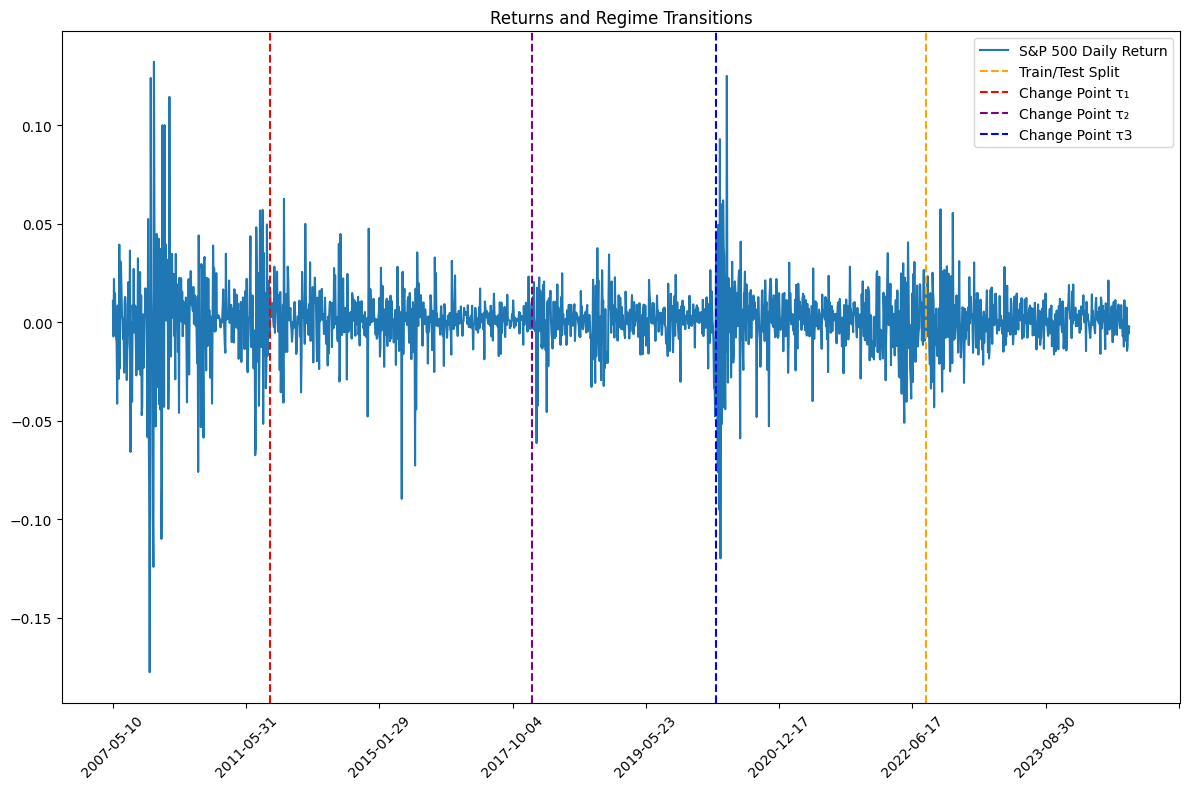

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate posterior means for change points
tau1_mean = int(np.mean(trace.posterior['tau1'].values))
tau2_mean = int(np.mean(trace.posterior['tau2'].values))
tau3_mean = int(np.mean(trace.posterior['tau3'].values))

# Create the figure and axis objects explicitly
fig, ax = plt.subplots(figsize=(12, 8))

# Plot returns and mark change points using the axis object
ax.plot(df['date.1'], df['ret_lag1'],label='S&P 500 Daily Return')
ax.axvline(df_train.iloc[-1]['date.1'], color='orange', linestyle='--', label='Train/Test Split')
ax.axvline(df.iloc[tau1_mean]['date.1'], color='red', linestyle='--', label='Change Point τ₁')
ax.axvline(df.iloc[tau2_mean]['date.1'], color='purple', linestyle='--', label='Change Point τ₂')
ax.axvline(df.iloc[tau3_mean]['date.1'], color='blue', linestyle='--', label='Change Point τ3')
# Set the title and legend
ax.set_title('Returns and Regime Transitions')
ax.legend()

# Format x-axis ticks - reduce the number of ticks to avoid overcrowding
# This is important if you have many dates
from matplotlib.dates import AutoDateLocator, DateFormatter
if pd.api.types.is_datetime64_any_dtype(df['date.1']):
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
else:
    # If not datetime, just use a reasonable number of ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))

# Rotate tick labels and make sure they don't overlap
plt.xticks(rotation=45)

# Adjust layout - note that tight_layout() should come AFTER setting ticker rotation
plt.subplots_adjust(bottom=0.2)  # Increase bottom margin specifically
plt.tight_layout()

# Save the figure before showing it - this can help diagnose issues
plt.savefig('returns_regimes_fixed.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [75]:
import numpy as np

train_ret = df_train['y']
test_ret  = df_test['y']

print("Train volatility (std):", np.std(train_ret))
print("Test volatility (std):",  np.std(test_ret))


Train volatility (std): 0.01969845367850678
Test volatility (std): 0.011114181819367559


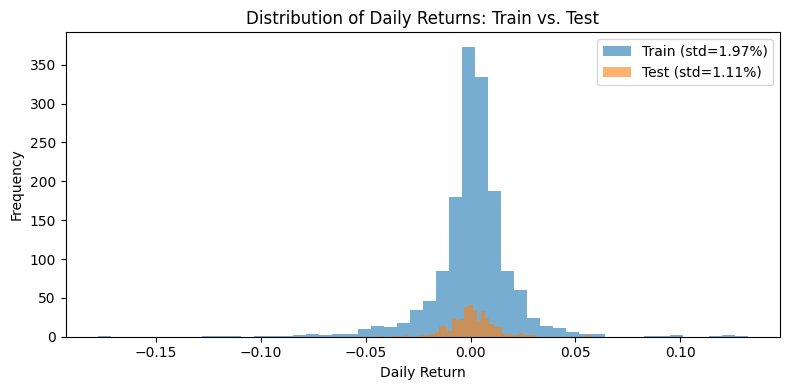

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df_train['y'], bins=50, alpha=0.6, label='Train (std=1.97%)')
plt.hist(df_test['y'],  bins=50, alpha=0.6, label='Test (std=1.11%)')
plt.legend()
plt.title("Distribution of Daily Returns: Train vs. Test")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


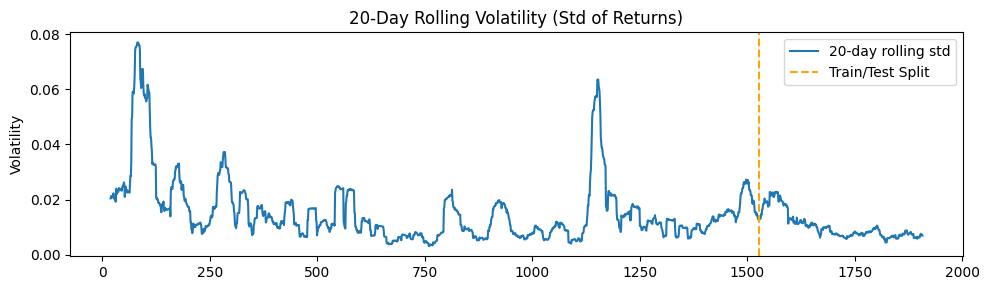

In [77]:
df['vol20'] = df['y'].rolling(20).std()
plt.figure(figsize=(10,3))
plt.plot(df.index, df['vol20'], label='20‑day rolling std')
plt.axvline(df_test.index[0], color='orange', ls='--', label='Train/Test Split')
plt.title("20‑Day Rolling Volatility (Std of Returns)")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()


What the Figure Suggests

Three Distinct Market Regimes:

Pre-τ₁ (before first red line): High volatility period with extreme downward movements (likely the 2008-2009 financial crisis)
Between τ₁ and τ₂: Relatively moderate volatility with smaller fluctuations
Around τ₂ (purple line): Another spike in volatility (likely the COVID-19 crash in 2020)
Post-τ₂: Mixed volatility continuing into your test set


Regime Persistence Question: The volatility profile changes throughout your dataset, suggesting regime-switching is appropriate, but the regimes don't appear to be strictly stationary.
Test Set Challenge: Your train/test split (orange line) occurs after both change points, which means your model learned regime shifts that occurred in the training data, but the test data may have different characteristics.

In [216]:
from scipy.stats import skew, kurtosis


In [62]:
from scipy.stats import skew, kurtosis

regime_stats = df.groupby('regime')['ret_lag1'].agg([
    'mean',
    'std',
    lambda x: skew(x, bias=False),
    lambda x: kurtosis(x, bias=False)
])

# Rename columns for clarity
regime_stats.columns = ['mean', 'std', 'skew', 'kurtosis']

print(regime_stats)

# Your change-point model appears to capture distinct statistical regimes:

# Regime 0: Volatile, flat (maybe pre-crisis or transition period).
# Regime 1: High-return, low-volatility (bullish/stable).
# Regime 2: Medium return, moderate volatility but high kurtosis (stable but with tail risk).
# This supports your earlier observations that test performance can exceed train performance if the test set lies in a more stable regime.

KeyError: 'regime'

You've got it! Let me explain the pipeline of this Bayesian change-point approach:

### 1. Model Building and Fitting Phase
In your existing `bayesian_cp_forecast` function:

- You define a probabilistic model with PyMC that includes:
  - A change-point parameter `tau` that follows a discrete uniform distribution
  - Two sets of regression parameters: one for before the change-point and one for after
  - A likelihood function that switches between the two parameter sets based on `tau`

- You run MCMC sampling (specifically NUTS - No U-Turn Sampler) to:
  - Explore the posterior distribution of all parameters
  - Jointly estimate where the change-point occurred and what the parameters are in each regime
  - Store all of these samples in the `trace` object, which contains thousands of plausible parameter combinations

- The function returns:
  - `model`: The PyMC model object that defines the structure
  - `trace`: The posterior samples for all parameters

### 2. Analysis and Interpretation
After fitting, you can:
- Visualize the posterior distribution of `tau` to see when the change likely occurred
- Examine the different regression coefficients to understand how relationships changed
- Compare volatility (`sigma_0` vs `sigma_1`) to see if market uncertainty changed

### 3. Prediction Phase
With the `predict_with_cp_model` function:

- You take new feature data that needs prediction
- You use the post-change-point parameters (since these represent the most recent regime)
- For each posterior sample (from thousands of MCMC draws), you:
  - Extract the parameter values (alpha_1, betas_1)
  - Calculate a prediction for the new data
  - This gives you thousands of plausible predictions based on different parameter combinations

- You summarize these predictions to get:
  - The mean prediction (central tendency)
  - Uncertainty intervals (95% credible intervals)
  - Standard deviation (prediction uncertainty)

The beauty of this Bayesian approach is that it fully accounts for uncertainty in:
1. The location of the change-point
2. The regression parameters in each regime
3. The resulting predictions

Rather than a single prediction value, you get an entire probability distribution of possible outcomes, which is particularly valuable in financial markets where understanding risk is crucial.

2 check points

In [63]:
import ruptures as rpt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az

In [65]:
# First, extract the tau1 and tau2 posterior samples
tau1_samples = trace.posterior['tau1'].values
tau2_samples = trace.posterior['tau2'].values
tau3_samples = trace.posterior['tau3'].values
# Compute posterior mean for tau1 and tau2
tau1_mean = tau1_samples.mean()
tau2_mean = tau2_samples.mean()
tau3_mean = tau3_samples.mean()
print(f"Estimated first change point (tau1) ≃ {tau1_mean}")
print(f"Estimated second change point (tau2) ≃ {tau2_mean}")

# Convert tau1 and tau2 indices to actual dates (using round to nearest integer)
tau1_pos = int(np.round(tau1_mean))  # Round to nearest integer index
tau2_pos = int(np.round(tau2_mean))  # Round to nearest integer index
tau3_pos = int(np.round(tau3_mean))  # Round to nearest integer index
# Ensure your df_train has a DateTime index, then map to corresponding dates
tau1_date = df_train.index[tau1_pos]  # Get the date corresponding to tau1
tau2_date = df_train.index[tau2_pos]  # Get the date corresponding to tau2
tau3_date = df_train.index[tau3_pos] 
# Print the estimated dates for the change points
print(f"Estimated first change point date ≃ {tau1_date.strftime('%Y-%m-%d')}")
print(f"Estimated second change point date ≃ {tau2_date.strftime('%Y-%m-%d')}")
print(f"Estimated second change point date ≃ {tau3_date.strftime('%Y-%m-%d')}")

Estimated first change point (tau1) ≃ 295.64742063786184
Estimated second change point (tau2) ≃ 787.6951915612461
Estimated first change point date ≃ 2012-01-10
Estimated second change point date ≃ 2018-01-16
Estimated second change point date ≃ 2020-03-06
